In [1]:
!pip install tensorflow matplotlib numpy opencv-python


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
base_path = "/content/drive/MyDrive/Xray/chest_xray"


In [9]:
train_path = base_path + "/train"
val_path = base_path + "/val"
test_path = base_path + "/test"

In [10]:
import os

valid_exts = [".jpg", ".jpeg", ".png", ".bmp"]

for root, dirs, files in os.walk(base_path):
    for f in files:
        if not any(f.lower().endswith(ext) for ext in valid_exts):
            try:
                os.remove(os.path.join(root, f))
                print("Removed:", f)
            except:
                pass


In [11]:
import os
import numpy as np
from PIL import Image

dataset_dir = "/content/drive/MyDrive/Xray/chest_xray"
img_size = (64, 64)

X, y = [], []
class_names = sorted(os.listdir(dataset_dir))
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

for cls in class_names:
    folder = os.path.join(dataset_dir, cls)
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        try:
            img = Image.open(path).convert("RGB").resize(img_size)
            arr = np.array(img) / 255.0
            X.append(arr.flatten())   # flatten for ANN
            y.append(class_to_idx[cls])
        except:
            pass  # skip non-image files

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape, "Labels:", len(y))
print("Classes:", class_names)

Dataset shape: (0,) Labels: 0
Classes: ['__MACOSX', 'chest_xray', 'test', 'train', 'val']


In [13]:
#One-hot encode labels
num_classes = len(class_names)
y_onehot = np.zeros((y.size, num_classes))

# Ensure y is of integer type before using it as an index
y_int = y.astype(int)
y_onehot[np.arange(y_int.size), y_int] = 1

In [18]:

X = []
y = []

data_path = "/content/drive/MyDrive/Xray/chest_xray/chest_xray/train"

for cls in ["PNEUMONIA", "NORMAL"]:
    folder = os.path.join(data_path, cls)
    label = 1 if cls == "PNEUMONIA" else 0

    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))
        X.append(img)
        y.append(label)

X = np.array(X)                # shape = (m, 64, 64, 3)
X = X.reshape(X.shape[0], -1)  # flatten → (m, 12288)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (5216, 12288)
y shape: (5216,)


In [19]:
num_classes = 2

y_onehot = np.zeros((y.size, num_classes))
y_onehot[np.arange(y.size), y] = 1

print(y_onehot.shape)


(5216, 2)


In [20]:
np.random.seed(42)
#Initialize ANN Weights

input_dim = X.shape[1]   # 12288
hidden_dim = 128
output_dim = num_classes

W1 = np.random.randn(input_dim, hidden_dim) * 0.01
b1 = np.zeros((1, hidden_dim))

W2 = np.random.randn(hidden_dim, output_dim) * 0.01
b2 = np.zeros((1, output_dim))


In [21]:

#Define Activation Functions

def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


In [22]:
#Cross-Entropy Loss

def cross_entropy(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m


In [23]:
lr = 0.001   # learning rate
epochs = 20

for epoch in range(epochs):
    # Forward pass
    Z1 = X.dot(W1) + b1
    A1 = relu(Z1)

    Z2 = A1.dot(W2) + b2
    A2 = softmax(Z2)

    # Loss
    loss = cross_entropy(y_onehot, A2)

    # Backpropagation
    m = X.shape[0]

    dZ2 = A2 - y_onehot
    dW2 = (A1.T).dot(dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = dZ2.dot(W2.T)
    dZ1 = dA1 * relu_deriv(Z1)
    dW1 = (X.T).dot(dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Update weights
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

    # Print progress
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")


Epoch 1/20 - Loss: 7.0735
Epoch 2/20 - Loss: 5.3278
Epoch 3/20 - Loss: 0.6886
Epoch 4/20 - Loss: 0.6602
Epoch 5/20 - Loss: 0.7919
Epoch 6/20 - Loss: 0.6894
Epoch 7/20 - Loss: 0.6839
Epoch 8/20 - Loss: 0.6382
Epoch 9/20 - Loss: 1.2350
Epoch 10/20 - Loss: 0.8915
Epoch 11/20 - Loss: 0.6923
Epoch 12/20 - Loss: 0.6915
Epoch 13/20 - Loss: 0.6894
Epoch 14/20 - Loss: 0.6747
Epoch 15/20 - Loss: 0.5992
Epoch 16/20 - Loss: 0.6949
Epoch 17/20 - Loss: 0.6920
Epoch 18/20 - Loss: 0.6918
Epoch 19/20 - Loss: 0.6915
Epoch 20/20 - Loss: 0.6911


In [24]:
def predict(X):
    Z1 = X.dot(W1) + b1
    A1 = relu(Z1)
    Z2 = A1.dot(W2) + b2
    A2 = softmax(Z2)
    return np.argmax(A2, axis=1)


In [25]:
y_pred = predict(X)
acc = np.mean(y_pred == y)
print("Training Accuracy:", acc)


Training Accuracy: 0.7377300613496932


Saving person94_bacteria_458.jpeg to person94_bacteria_458.jpeg

Prediction: PNEUMONIA


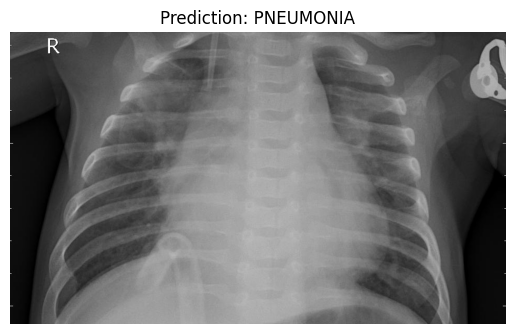

In [28]:
from google.colab import files
import matplotlib.pyplot as plt # Import matplotlib for plotting

uploaded = files.upload()
file_name = list(uploaded.keys())[0]

def predict_single_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img_flat = img.reshape(1, -1)

    Z1 = img_flat.dot(W1) + b1
    A1 = relu(Z1)
    Z2 = A1.dot(W2) + b2
    A2 = softmax(Z2)

    pred = np.argmax(A2, axis=1)[0]
    return "PNEUMONIA" if pred == 1 else "NORMAL"

# Run prediction
result = predict_single_image(file_name)
print("\nPrediction:", result)

# Show image
img = cv2.imread(file_name)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Prediction: " + result)
plt.axis("off")
plt.show()
